In [38]:
# data
import pandas as pd
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy import stats

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
import tensorflow as tf
from sklearn import ensemble, tree, linear_model
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.utils import shuffle
import xgboost as xgb

# tqdm
from tqdm import tqdm_notebook as tqdm

tf.set_random_seed(777)  # reproducibility

# layers
from tensorflow.contrib.layers import fully_connected, batch_norm, dropout
from tensorflow.contrib.framework import arg_scope

In [2]:
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')
combine = [train_df, test_df]

In [3]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


/Users/outtoin/.pyenv/versions/3.5.2/Python.framework/Versions/3.5/lib/python3.5/site-packages/seaborn/matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/Users/outtoin/.pyenv/versions/3.5.2/Python.framework/Versions/3.5/lib/python3.5/site-packages/seaborn/matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


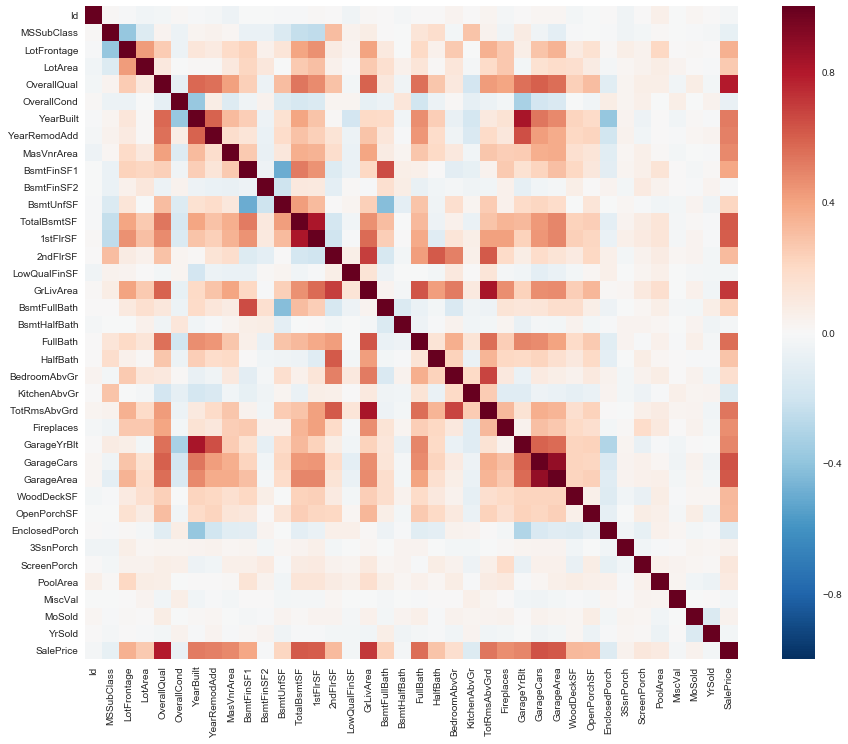

In [5]:
corrmat = train_df.corr()
f, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(corrmat, vmax=1.0, square=True);

/Users/outtoin/.pyenv/versions/3.5.2/Python.framework/Versions/3.5/lib/python3.5/site-packages/seaborn/matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/Users/outtoin/.pyenv/versions/3.5.2/Python.framework/Versions/3.5/lib/python3.5/site-packages/seaborn/matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


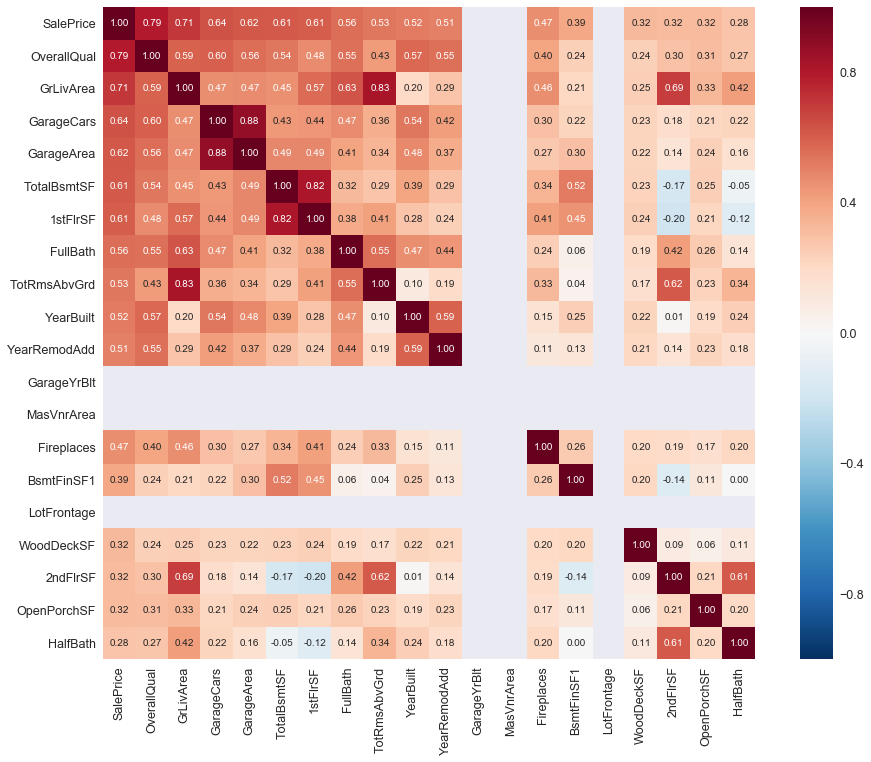

In [6]:
k_number = 20
cols = corrmat.nlargest(k_number, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train_df[cols].values.T)
sns.set(font_scale=1.25)
f, ax = plt.subplots(figsize=(16, 12))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10},
                yticklabels=cols.values, xticklabels=cols.values)

In [7]:
train_df[['MSSubClass', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2']].head(20)

,MSSubClass,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2
0,60,GLQ,706,Unf,0
1,20,ALQ,978,Unf,0
2,60,GLQ,486,Unf,0
3,70,ALQ,216,Unf,0
4,60,GLQ,655,Unf,0
5,50,GLQ,732,Unf,0
6,20,GLQ,1369,Unf,0
7,60,ALQ,859,BLQ,32
8,50,Unf,0,Unf,0
9,190,GLQ,851,Unf,0


In [8]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [9]:
train_labels = train_df.pop('SalePrice')
train_labels

0       208500
1       181500
2       223500
3       140000
4       250000
5       143000
6       307000
7       200000
8       129900
9       118000
10      129500
11      345000
12      144000
13      279500
14      157000
15      132000
16      149000
17       90000
18      159000
19      139000
20      325300
21      139400
22      230000
23      129900
24      154000
25      256300
26      134800
27      306000
28      207500
29       68500
         ...  
1430    192140
1431    143750
1432     64500
1433    186500
1434    160000
1435    174000
1436    120500
1437    394617
1438    149700
1439    197000
1440    191000
1441    149300
1442    310000
1443    121000
1444    179600
1445    129000
1446    157900
1447    240000
1448    112000
1449     92000
1450    136000
1451    287090
1452    145000
1453     84500
1454    185000
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, Length: 1460, dtype: int64

In [10]:
features = pd.concat([train_df, test_df], keys = ['train_df', 'test_df'])
features

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley  \
train_df 0        1          60       RL         65.0     8450   Pave   NaN   
         1        2          20       RL         80.0     9600   Pave   NaN   
         2        3          60       RL         68.0    11250   Pave   NaN   
         3        4          70       RL         60.0     9550   Pave   NaN   
         4        5          60       RL         84.0    14260   Pave   NaN   
         5        6          50       RL         85.0    14115   Pave   NaN   
         6        7          20       RL         75.0    10084   Pave   NaN   
         7        8          60       RL          NaN    10382   Pave   NaN   
         8        9          50       RM         51.0     6120   Pave   NaN   
         9       10         190       RL         50.0     7420   Pave   NaN   
         10      11          20       RL         70.0    11200   Pave   NaN   
         11      12          60       RL         85.0    11924   Pave   NaN   
         12      13          20       RL          NaN    12968   Pave   NaN   
         13      14          20       RL         91.0    10652   Pave   NaN   
         14      15          20       RL          NaN    10920   Pave   NaN   
         15      16          45       RM         51.0     6120   Pave   NaN   
         16      17          20       RL          NaN    11241   Pave   NaN   
         17      18          90       RL         72.0    10791   Pave   NaN   
         18      19          20       RL         66.0    13695   Pave   NaN   
         19      20          20       RL         70.0     7560   Pave   NaN   
         20      21          60       RL        101.0    14215   Pave   NaN   
         21      22          45       RM         57.0     7449   Pave  Grvl   
         22      23          20       RL         75.0     9742   Pave   NaN   
         23      24         120       RM         44.0     4224   Pave   NaN   
         24      25          20       RL          NaN     8246   Pave   NaN   
         25      26          20       RL        110.0    14230   Pave   NaN   
         26      27          20       RL         60.0     7200   Pave   NaN   
         27      28          20       RL         98.0    11478   Pave   NaN   
         28      29          20       RL         47.0    16321   Pave   NaN   
         29      30          30       RM         60.0     6324   Pave   NaN   
...             ...         ...      ...          ...      ...    ...   ...   
test_df  1429  2890          30       RM         50.0     7030   Pave   NaN   
         1430  2891          50       RM         75.0     9060   Pave   NaN   
         1431  2892          30  C (all)         69.0    12366   Pave   NaN   
         1432  2893         190  C (all)         50.0     9000   Pave   NaN   
         1433  2894          50  C (all)         60.0     8520   Grvl   NaN   
         1434  2895         120       RM         41.0     5748   Pave   NaN   
         1435  2896         120       RM         44.0     3842   Pave   NaN   
         1436  2897          20       RL         69.0    23580   Pave   NaN   
         1437  2898          90       RL         65.0     8385   Pave   NaN   
         1438  2899          20       RL         70.0     9116   Pave   NaN   
         1439  2900          80       RL        140.0    11080   Pave   NaN   
         1440  2901          20       RL          NaN    50102   Pave   NaN   
         1441  2902          20       RL          NaN     8098   Pave   NaN   
         1442  2903          20       RL         95.0    13618   Pave   NaN   
         1443  2904          20       RL         88.0    11577   Pave   NaN   
         1444  2905          20      NaN        125.0    31250   Pave   NaN   
         1445  2906          90       RM         78.0     7020   Pave   NaN   
         1446  2907         160       RM         41.0     2665   Pave   NaN   
         1447  2908          20       RL         58.0    10172   Pa

In [11]:
NAs = pd.concat([train_df.isnull().sum().sort_values(ascending=False), test_df.isnull().sum().sort_values(ascending=False)], axis=1, keys=['Train', 'Test'])
NAs[NAs.sum(axis=1) > 0]

,Train,Test
Alley,1369,1352
BsmtCond,37,45
BsmtExposure,38,44
BsmtFinSF1,0,1
BsmtFinSF2,0,1
BsmtFinType1,37,42
BsmtFinType2,38,42
BsmtFullBath,0,2
BsmtHalfBath,0,2
BsmtQual,37,44


In [12]:
features.drop(['Utilities', 'RoofMatl', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'Heating', 'LowQualFinSF',
               'BsmtFullBath', 'BsmtHalfBath', 'Functional', 'GarageYrBlt', 'GarageArea', 'GarageCond', 'WoodDeckSF',
               'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal'],
              axis=1, inplace=True)
features

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley  \
train_df 0        1          60       RL         65.0     8450   Pave   NaN   
         1        2          20       RL         80.0     9600   Pave   NaN   
         2        3          60       RL         68.0    11250   Pave   NaN   
         3        4          70       RL         60.0     9550   Pave   NaN   
         4        5          60       RL         84.0    14260   Pave   NaN   
         5        6          50       RL         85.0    14115   Pave   NaN   
         6        7          20       RL         75.0    10084   Pave   NaN   
         7        8          60       RL          NaN    10382   Pave   NaN   
         8        9          50       RM         51.0     6120   Pave   NaN   
         9       10         190       RL         50.0     7420   Pave   NaN   
         10      11          20       RL         70.0    11200   Pave   NaN   
         11      12          60       RL         85.0    11924   Pave   NaN   
         12      13          20       RL          NaN    12968   Pave   NaN   
         13      14          20       RL         91.0    10652   Pave   NaN   
         14      15          20       RL          NaN    10920   Pave   NaN   
         15      16          45       RM         51.0     6120   Pave   NaN   
         16      17          20       RL          NaN    11241   Pave   NaN   
         17      18          90       RL         72.0    10791   Pave   NaN   
         18      19          20       RL         66.0    13695   Pave   NaN   
         19      20          20       RL         70.0     7560   Pave   NaN   
         20      21          60       RL        101.0    14215   Pave   NaN   
         21      22          45       RM         57.0     7449   Pave  Grvl   
         22      23          20       RL         75.0     9742   Pave   NaN   
         23      24         120       RM         44.0     4224   Pave   NaN   
         24      25          20       RL          NaN     8246   Pave   NaN   
         25      26          20       RL        110.0    14230   Pave   NaN   
         26      27          20       RL         60.0     7200   Pave   NaN   
         27      28          20       RL         98.0    11478   Pave   NaN   
         28      29          20       RL         47.0    16321   Pave   NaN   
         29      30          30       RM         60.0     6324   Pave   NaN   
...             ...         ...      ...          ...      ...    ...   ...   
test_df  1429  2890          30       RM         50.0     7030   Pave   NaN   
         1430  2891          50       RM         75.0     9060   Pave   NaN   
         1431  2892          30  C (all)         69.0    12366   Pave   NaN   
         1432  2893         190  C (all)         50.0     9000   Pave   NaN   
         1433  2894          50  C (all)         60.0     8520   Grvl   NaN   
         1434  2895         120       RM         41.0     5748   Pave   NaN   
         1435  2896         120       RM         44.0     3842   Pave   NaN   
         1436  2897          20       RL         69.0    23580   Pave   NaN   
         1437  2898          90       RL         65.0     8385   Pave   NaN   
         1438  2899          20       RL         70.0     9116   Pave   NaN   
         1439  2900          80       RL        140.0    11080   Pave   NaN   
         1440  2901          20       RL          NaN    50102   Pave   NaN   
         1441  2902          20       RL          NaN     8098   Pave   NaN   
         1442  2903          20       RL         95.0    13618   Pave   NaN   
         1443  2904          20       RL         88.0    11577   Pave   NaN   
         1444  2905          20      NaN        125.0    31250   Pave   NaN   
         1445  2906          90       RM         78.0     7020   Pave   NaN   
         1446  2907         160       RM         41.0     2665   Pave   NaN   
         1447  2908          20       RL         58.0    10172   Pa

In [13]:
# MSSubClass as str
features['MSSubClass'] = features['MSSubClass'].astype(str)

# MSZoning NA in pred. filling with most popular values
features['MSZoning'] = features['MSZoning'].fillna(features['MSZoning'].mode()[0])

# LotFrontage  NA in all. I suppose NA means 0
features['LotFrontage'] = features['LotFrontage'].fillna(features['LotFrontage'].mean())

# TotalBsmtSF  NA in pred. I suppose NA means 0
features['TotalBsmtSF'] = features['TotalBsmtSF'].fillna(0)

# Converting OverallCond to str
features.OverallCond = features.OverallCond.astype(str)

# MasVnrType NA in all. filling with most popular values
features['MasVnrType'] = features['MasVnrType'].fillna(features['MasVnrType'].mode()[0])

# BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2
# NA in all. NA means No basement
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    features[col] = features[col].fillna('NoBSMT')

# Electrical NA in pred. filling with most popular values
features['Electrical'] = features['Electrical'].fillna(features['Electrical'].mode()[0])

# KitchenQual NA in pred. filling with most popular values
features['KitchenQual'] = features['KitchenQual'].fillna(features['KitchenQual'].mode()[0])

# FireplaceQu  NA in all. NA means No Fireplace
features['FireplaceQu'] = features['FireplaceQu'].fillna('NoFP')

# GarageCars  NA in pred. I suppose NA means 0
features['GarageCars'] = features['GarageCars'].fillna(0.0)

# SaleType NA in pred. filling with most popular values
features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])

# Month to categorical
features['YrSold'] = features['YrSold'].astype(str)
features['MoSold'] = features['MoSold'].astype(str)

# Adding total sqfootage feature and removing Basement, 1st and 2nd floor features
features['TotalSF'] = features['TotalBsmtSF'] + features['1stFlrSF'] + features['2ndFlrSF']
features.drop(['TotalBsmtSF', '1stFlrSF', '2ndFlrSF'], axis=1, inplace=True)

In [14]:
features.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'HeatingQC', 'CentralAir', 'Electrical', 'GrLivArea',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageCars', 'GarageQual', 'PavedDrive', 'MoSold',
       'YrSold', 'SaleType', 'SaleCondition', 'TotalSF'],
      dtype='object')

In [15]:
features = features.drop(['LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Condition1', 'Condition2',
               'YearRemodAdd', 'Exterior1st', 'Exterior2nd', 'Alley', 
               'BsmtExposure'], axis=1)

In [16]:
features

Id MSSubClass MSZoning  LotFrontage  LotArea Street  \
train_df 0        1         60       RL    65.000000     8450   Pave   
         1        2         20       RL    80.000000     9600   Pave   
         2        3         60       RL    68.000000    11250   Pave   
         3        4         70       RL    60.000000     9550   Pave   
         4        5         60       RL    84.000000    14260   Pave   
         5        6         50       RL    85.000000    14115   Pave   
         6        7         20       RL    75.000000    10084   Pave   
         7        8         60       RL    69.305795    10382   Pave   
         8        9         50       RM    51.000000     6120   Pave   
         9       10        190       RL    50.000000     7420   Pave   
         10      11         20       RL    70.000000    11200   Pave   
         11      12         60       RL    85.000000    11924   Pave   
         12      13         20       RL    69.305795    12968   Pave   
         13      14         20       RL    91.000000    10652   Pave   
         14      15         20       RL    69.305795    10920   Pave   
         15      16         45       RM    51.000000     6120   Pave   
         16      17         20       RL    69.305795    11241   Pave   
         17      18         90       RL    72.000000    10791   Pave   
         18      19         20       RL    66.000000    13695   Pave   
         19      20         20       RL    70.000000     7560   Pave   
         20      21         60       RL   101.000000    14215   Pave   
         21      22         45       RM    57.000000     7449   Pave   
         22      23         20       RL    75.000000     9742   Pave   
         23      24        120       RM    44.000000     4224   Pave   
         24      25         20       RL    69.305795     8246   Pave   
         25      26         20       RL   110.000000    14230   Pave   
         26      27         20       RL    60.000000     7200   Pave   
         27      28         20       RL    98.000000    11478   Pave   
         28      29         20       RL    47.000000    16321   Pave   
         29      30         30       RM    60.000000     6324   Pave   
...             ...        ...      ...          ...      ...    ...   
test_df  1429  2890         30       RM    50.000000     7030   Pave   
         1430  2891         50       RM    75.000000     9060   Pave   
         1431  2892         30  C (all)    69.000000    12366   Pave   
         1432  2893        190  C (all)    50.000000     9000   Pave   
         1433  2894         50  C (all)    60.000000     8520   Grvl   
         1434  2895        120       RM    41.000000     5748   Pave   
         1435  2896        120       RM    44.000000     3842   Pave   
         1436  2897         20       RL    69.000000    23580   Pave   
         1437  2898         90       RL    65.000000     8385   Pave   
         1438  2899         20       RL    70.000000     9116   Pave   
         1439  2900         80       RL   140.000000    11080   Pave   
         1440  2901         20       RL    69.305795    50102   Pave   
         1441  2902         20       RL    69.305795     8098   Pave   
         1442  2903         20       RL    95.000000    13618   Pave   
         1443  2904         20       RL    88.000000    11577   Pave   
         1444  2905         20       RL   125.000000    31250   Pave   
         1445  2906         90       RM    78.000000     7020   Pave   
         1446  2907        160       RM    41.000000     2665   Pave   
         1447  2908         20       RL    58.000000    10172   Pave   
         1448  2909         90       RL    69.305795    11836   Pave   
         1449  2910        180       RM    21.000000     1470   Pave   
         1450  2911        160       RM    21.000000     1484   Pave   
         1451  2912         20       RL    80.000000    13384   Pave   
         1452  2913        160       RM    21.000000     

In [17]:
features.describe()

,Id,LotFrontage,LotArea,OverallQual,YearBuilt,GrLivArea,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,TotalSF
count,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.00000
mean,1460.000000,69.305795,10168.114080,6.089072,1971.312778,1500.759849,1.568003,0.380267,2.860226,1.044536,6.451524,0.597122,1.766016,2547.48270
std,842.787043,21.312345,7886.996359,1.409947,30.291442,506.051045,0.552969,0.502872,0.822693,0.214462,1.569379,0.646129,0.762196,805.12084
min,1.000000,21.000000,1300.000000,1.000000,1872.000000,334.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,334.00000
25%,730.500000,60.000000,7478.000000,5.000000,1953.500000,1126.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1.000000,2000.00000
50%,1460.000000,69.305795,9453.000000,6.000000,1973.000000,1444.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,2.000000,2448.00000
75%,2189.500000,78.000000,11570.000000,7.000000,2001.000000,1743.500000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2.000000,2991.50000
max,2919.000000,313.000000,215245.000000,10.000000,2010.000000,5642.000000,4.000000,2.000000,8.000000,3.000000,15.000000,4.000000,5.000000,11752.00000


In [18]:
features.describe(include=['O'])

,MSSubClass,MSZoning,Street,Neighborhood,BldgType,HouseStyle,OverallCond,RoofStyle,MasVnrType,ExterQual,...,KitchenQual,FireplaceQu,GarageType,GarageFinish,GarageQual,PavedDrive,MoSold,YrSold,SaleType,SaleCondition
count,2919,2919,2919,2919,2919,2919,2919,2919,2919,2919,...,2919,2919,2762,2760,2760,2919,2919,2919,2919,2919
unique,16,5,2,25,5,8,9,6,4,4,...,4,6,6,3,5,3,12,5,9,6
top,20,RL,Pave,NAmes,1Fam,1Story,5,Gable,None,TA,...,TA,NoFP,Attchd,Unf,TA,Y,6,2007,WD,Normal
freq,1079,2269,2907,443,2425,1471,1645,2310,1766,1798,...,1493,1420,1723,1230,2604,2641,503,692,2526,2402


In [19]:
x_features = features
features

Id MSSubClass MSZoning  LotFrontage  LotArea Street  \
train_df 0        1         60       RL    65.000000     8450   Pave   
         1        2         20       RL    80.000000     9600   Pave   
         2        3         60       RL    68.000000    11250   Pave   
         3        4         70       RL    60.000000     9550   Pave   
         4        5         60       RL    84.000000    14260   Pave   
         5        6         50       RL    85.000000    14115   Pave   
         6        7         20       RL    75.000000    10084   Pave   
         7        8         60       RL    69.305795    10382   Pave   
         8        9         50       RM    51.000000     6120   Pave   
         9       10        190       RL    50.000000     7420   Pave   
         10      11         20       RL    70.000000    11200   Pave   
         11      12         60       RL    85.000000    11924   Pave   
         12      13         20       RL    69.305795    12968   Pave   
         13      14         20       RL    91.000000    10652   Pave   
         14      15         20       RL    69.305795    10920   Pave   
         15      16         45       RM    51.000000     6120   Pave   
         16      17         20       RL    69.305795    11241   Pave   
         17      18         90       RL    72.000000    10791   Pave   
         18      19         20       RL    66.000000    13695   Pave   
         19      20         20       RL    70.000000     7560   Pave   
         20      21         60       RL   101.000000    14215   Pave   
         21      22         45       RM    57.000000     7449   Pave   
         22      23         20       RL    75.000000     9742   Pave   
         23      24        120       RM    44.000000     4224   Pave   
         24      25         20       RL    69.305795     8246   Pave   
         25      26         20       RL   110.000000    14230   Pave   
         26      27         20       RL    60.000000     7200   Pave   
         27      28         20       RL    98.000000    11478   Pave   
         28      29         20       RL    47.000000    16321   Pave   
         29      30         30       RM    60.000000     6324   Pave   
...             ...        ...      ...          ...      ...    ...   
test_df  1429  2890         30       RM    50.000000     7030   Pave   
         1430  2891         50       RM    75.000000     9060   Pave   
         1431  2892         30  C (all)    69.000000    12366   Pave   
         1432  2893        190  C (all)    50.000000     9000   Pave   
         1433  2894         50  C (all)    60.000000     8520   Grvl   
         1434  2895        120       RM    41.000000     5748   Pave   
         1435  2896        120       RM    44.000000     3842   Pave   
         1436  2897         20       RL    69.000000    23580   Pave   
         1437  2898         90       RL    65.000000     8385   Pave   
         1438  2899         20       RL    70.000000     9116   Pave   
         1439  2900         80       RL   140.000000    11080   Pave   
         1440  2901         20       RL    69.305795    50102   Pave   
         1441  2902         20       RL    69.305795     8098   Pave   
         1442  2903         20       RL    95.000000    13618   Pave   
         1443  2904         20       RL    88.000000    11577   Pave   
         1444  2905         20       RL   125.000000    31250   Pave   
         1445  2906         90       RM    78.000000     7020   Pave   
         1446  2907        160       RM    41.000000     2665   Pave   
         1447  2908         20       RL    58.000000    10172   Pave   
         1448  2909         90       RL    69.305795    11836   Pave   
         1449  2910        180       RM    21.000000     1470   Pave   
         1450  2911        160       RM    21.000000     1484   Pave   
         1451  2912         20       RL    80.000000    13384   Pave   
         1452  2913        160       RM    21.000000     

### Standardizing numeric data

In [20]:
numeric_features = x_features.loc[:, ['LotFrontage', 'LotArea', 'GrLivArea', 'TotalSF']]
numeric_features_standardized = (numeric_features - numeric_features.mean()) / numeric_features.std()

numeric_features_standardized

LotFrontage   LotArea  GrLivArea   TotalSF
train_df 0    -2.020329e-01 -0.217841   0.413476  0.022999
         1     5.017845e-01 -0.072032  -0.471810 -0.029167
         2    -6.126943e-02  0.137173   0.563659  0.196886
         3    -4.366387e-01 -0.078371   0.427309 -0.092511
         4     6.894691e-01  0.518814   1.377806  0.988072
         5     7.363903e-01  0.500430  -0.274201 -0.483757
         6     2.671787e-01 -0.010665   0.381859  1.034028
         7    -1.800332e-14  0.027119   1.164389  0.806733
         8    -8.589292e-01 -0.513264   0.539946  0.221727
         9    -9.058503e-01 -0.348436  -0.837386 -0.595541
         10    3.257289e-02  0.130834  -0.910501 -0.580637
         11    7.363903e-01  0.222630   1.626793  1.181832
         12   -1.800332e-14  0.355000  -1.163440 -0.898601
         13    1.017917e+00  0.061352  -0.013358  0.547144
         14   -1.800332e-14  0.095332  -0.489595 -0.051524
         15   -8.589292e-01 -0.513264  -1.278053 -1.070004
         16   -1.800332e-14  0.136032  -0.981640 -0.670064
         17    1.264152e-01  0.078976  -0.404623 -1.554404
         18   -1.551118e-01  0.447177  -0.764270 -0.396813
         19    3.257289e-02 -0.330685  -0.319651 -0.222926
         20    1.487129e+00  0.513109   1.729549  1.225303
         21   -5.774022e-01 -0.344759  -0.776127 -0.996723
         22    2.671787e-01 -0.054027   0.581444  1.272501
         23   -1.187377e+00 -0.753660  -0.870979 -0.555796
         24   -1.800332e-14 -0.243707  -0.870979 -0.530955
         25    1.909419e+00  0.515010   0.196107  0.768229
         26   -4.366387e-01 -0.376330  -1.187153 -0.928411
         27    1.346365e+00  0.166082   0.401620  1.068805
         28   -1.046614e+00  0.780130   0.196107  0.666381
         29   -4.366387e-01 -0.487399  -1.938065 -1.872368
...                     ...       ...        ...       ...
test_df  1429 -9.058503e-01 -0.397885  -1.698959 -1.571792
         1430  2.671787e-01 -0.140499   0.271198  0.071439
         1431 -1.434827e-02  0.278672  -1.525063 -2.258646
         1432 -9.058503e-01 -0.148106  -0.207014 -0.610446
         1433 -4.366387e-01 -0.208966  -1.116014 -1.733259
         1434 -1.328141e+00 -0.560431   0.547850  0.998008
         1435 -1.187377e+00 -0.802094   0.287007  0.860141
         1436 -1.434827e-02  1.700506   0.245509  0.872561
         1437 -2.020329e-01 -0.226083   0.322576  0.969441
         1438  3.257289e-02 -0.133399  -0.019286  0.539692
         1439  3.317054e+00  0.115619  -0.574566 -0.260188
         1440 -1.800332e-14  5.063257   0.294911  0.912307
         1441 -1.800332e-14 -0.262472  -0.193182  0.293766
         1442  1.205602e+00  0.437414   0.907498  1.416579
         1443  8.771538e-01  0.178634   0.666415  1.401674
         1444  2.613237e+00  2.672993   0.196107 -1.176820
         1445  4.079422e-01 -0.399152  -0.262345  0.134784
         1446 -1.328141e+00 -0.951327  -0.388814 -1.216566
         1447 -5.304810e-01  0.000493  -1.238531 -1.005418
         1448 -1.800332e-14  0.211473   0.298863  0.939632
         1449 -2.266564e+00 -1.102842  -1.720696 -1.599117
         1450 -2.266564e+00 -1.101067  -0.807744 -1.129623
         1451  5.017845e-01  0.407745  -0.278153 -0.103690
         1452 -2.266564e+00 -1.094855  -0.807744 -1.129623
         1453 -2.266564e+00 -1.095742  -0.807744 -1.129623
         1454 -2.266564e+00 -1.043758  -0.807744 -1.129623
         1455 -2.266564e+00 -1.049083  -0.807744 -1.129623
         1456  4.255477e+00  1.246594  -0.546901 -0.123562
         1457 -3.427964e-01  0.034599  -1.048827 -0.826563
         1458  2.202575e-01 -0.068608   0.986541  0.557081

[2919 rows x 4 columns]

In [21]:
numeric_features1 = x_features.loc[:, ['LotFrontage', 'LotArea', 'GrLivArea', 'TotalSF']]
numeric_features_logged = np.log(numeric_features1)

numeric_features_logged

LotFrontage    LotArea  GrLivArea   TotalSF
train_df 0        4.174387   9.041922   7.444249  7.850104
         1        4.382027   9.169518   7.140453  7.833600
         2        4.219508   9.328123   7.487734  7.903227
         3        4.094345   9.164296   7.448334  7.813187
         4        4.430817   9.565214   7.695303  8.114624
         5        4.442651   9.554993   7.216709  7.676937
         6        4.317488   9.218705   7.434848  8.125631
         7        4.238529   9.247829   7.644919  8.069968
         8        3.931826   8.719317   7.480992  7.910591
         9        3.912023   8.911934   6.981935  7.634337
         10       4.248495   9.323669   6.946976  7.640123
         11       4.442651   9.386308   7.751045  8.160232
         12       4.238529   9.470240   6.815640  7.508787
         13       4.510860   9.273503   7.309212  8.002360
         14       4.238529   9.298351   7.133296  7.826443
         15       3.931826   8.719317   6.749931  7.430114
         16       4.238529   9.327323   6.911747  7.604894
         17       4.276666   9.286468   7.167038  7.167038
         18       4.189655   9.524786   7.015712  7.708860
         19       4.248495   8.930626   7.199678  7.769801
         20       4.615121   9.562053   7.773174  8.170186
         21       4.043051   8.915835   7.010312  7.464510
         22       4.317488   9.184202   7.492760  8.180881
         23       3.784190   8.348538   6.966024  7.649693
         24       4.238529   9.017484   6.966024  7.659171
         25       4.700480   9.563108   7.377759  8.060224
         26       4.094345   8.881836   6.802395  7.495542
         27       4.584967   9.348187   7.440734  8.133881
         28       3.850148   9.700208   7.377759  8.033983
         29       4.094345   8.752107   6.253829  6.946976
...                    ...        ...        ...       ...
test_df  1429     3.912023   8.857942   6.463029  7.156177
         1430     4.317488   9.111624   7.401231  7.865188
         1431     4.234107   9.422706   6.591674  6.591674
         1432     3.912023   9.104980   7.241366  7.628518
         1433     4.094345   9.050172   6.841615  7.049255
         1434     3.713572   8.656607   7.483244  8.117014
         1435     3.784190   8.253748   7.406103  8.083329
         1436     4.234107  10.068154   7.393263  8.086410
         1437     4.174387   9.034200   7.416980  8.110127
         1438     4.248495   9.117786   7.307202  8.000349
         1439     4.941642   9.312897   7.098376  7.757051
         1440     4.238529  10.821816   7.408531  8.096208
         1441     4.238529   8.999372   7.246368  7.931644
         1442     4.553877   9.519148   7.580700  8.212840
         1443     4.477337   9.356776   7.516433  8.209580
         1444     4.828314  10.349775   7.377759  7.377759
         1445     4.356709   8.856518   7.221105  7.884577
         1446     3.713572   7.887959   7.173192  7.357556
         1447     4.060443   9.227394   6.773080  7.460490
         1448     4.238529   9.378901   7.409742  8.102889
         1449     3.044522   7.293018   6.445720  7.138867
         1450     3.044522   7.302496   6.995766  7.401231
         1451     4.382027   9.501815   7.215240  7.809541
         1452     3.044522   7.334982   6.995766  7.401231
         1453     3.044522   7.330405   6.995766  7.401231
         1454     3.044522   7.568379   6.995766  7.401231
         1455     3.044522   7.546446   6.995766  7.401231
         1456     5.075174   9.903488   7.109879  7.803027
         1457     4.127134   9.253496   6.877296  7.540090
         1458     4.304065   9.172327   7.600902  8.005033

[2919 rows x 4 columns]

In [22]:
x_features.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Neighborhood', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'YearBuilt', 'RoofStyle', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2',
       'HeatingQC', 'CentralAir', 'Electrical', 'GrLivArea', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageCars', 'GarageQual', 'PavedDrive', 'MoSold',
       'YrSold', 'SaleType', 'SaleCondition', 'TotalSF'],
      dtype='object')

### Converting categorical data to dummies

In [23]:
for col in x_features.dtypes[x_features.dtypes == 'object'].index:
    for_dummy = x_features.pop(col)
    x_features = pd.concat([x_features, pd.get_dummies(for_dummy, prefix=col)], axis=1)
    
x_features

Id  LotFrontage  LotArea  OverallQual  YearBuilt  GrLivArea  \
train_df 0        1    65.000000     8450            7       2003       1710   
         1        2    80.000000     9600            6       1976       1262   
         2        3    68.000000    11250            7       2001       1786   
         3        4    60.000000     9550            7       1915       1717   
         4        5    84.000000    14260            8       2000       2198   
         5        6    85.000000    14115            5       1993       1362   
         6        7    75.000000    10084            8       2004       1694   
         7        8    69.305795    10382            7       1973       2090   
         8        9    51.000000     6120            7       1931       1774   
         9       10    50.000000     7420            5       1939       1077   
         10      11    70.000000    11200            5       1965       1040   
         11      12    85.000000    11924            9       2005       2324   
         12      13    69.305795    12968            5       1962        912   
         13      14    91.000000    10652            7       2006       1494   
         14      15    69.305795    10920            6       1960       1253   
         15      16    51.000000     6120            7       1929        854   
         16      17    69.305795    11241            6       1970       1004   
         17      18    72.000000    10791            4       1967       1296   
         18      19    66.000000    13695            5       2004       1114   
         19      20    70.000000     7560            5       1958       1339   
         20      21   101.000000    14215            8       2005       2376   
         21      22    57.000000     7449            7       1930       1108   
         22      23    75.000000     9742            8       2002       1795   
         23      24    44.000000     4224            5       1976       1060   
         24      25    69.305795     8246            5       1968       1060   
         25      26   110.000000    14230            8       2007       1600   
         26      27    60.000000     7200            5       1951        900   
         27      28    98.000000    11478            8       2007       1704   
         28      29    47.000000    16321            5       1957       1600   
         29      30    60.000000     6324            4       1927        520   
...             ...          ...      ...          ...        ...        ...   
test_df  1429  2890    50.000000     7030            4       1925        641   
         1430  2891    75.000000     9060            6       1957       1638   
         1431  2892    69.000000    12366            3       1945        729   
         1432  2893    50.000000     9000            5       1951       1396   
         1433  2894    60.000000     8520            3       1916        936   
         1434  2895    41.000000     5748            8       2005       1778   
         1435  2896    44.000000     3842            8       2004       1646   
         1436  2897    69.000000    23580            6       1979       1625   
         1437  2898    65.000000     8385            6       1978       1664   
         1438  2899    70.000000     9116            8       2001       1491   
         1439  2900   140.000000    11080            6       1975       1210   
         1440  2901    69.305795    50102            6       1958       1650   
         1441  2902    69.305795     8098            6       2000       1403   
         1442  2903    95.000000    13618            8       2005       1960   
         1443  2904    88.000000    11577            9       2005       1838   
         1444  2905   125.000000    31250            1       1951       1600   
         1445  2906    78.000000     7020            7       1997       1368   
         1446  2907    41.000000     2665            5       1977       1304   
         1447  29

### Obtaining standardized dataset

In [24]:
x_features_logged = x_features.copy()
x_features_logged.update(numeric_features_logged)

x_features_logged

Id  LotFrontage    LotArea  OverallQual  YearBuilt  \
train_df 0        1     4.174387   9.041922            7       2003   
         1        2     4.382027   9.169518            6       1976   
         2        3     4.219508   9.328123            7       2001   
         3        4     4.094345   9.164296            7       1915   
         4        5     4.430817   9.565214            8       2000   
         5        6     4.442651   9.554993            5       1993   
         6        7     4.317488   9.218705            8       2004   
         7        8     4.238529   9.247829            7       1973   
         8        9     3.931826   8.719317            7       1931   
         9       10     3.912023   8.911934            5       1939   
         10      11     4.248495   9.323669            5       1965   
         11      12     4.442651   9.386308            9       2005   
         12      13     4.238529   9.470240            5       1962   
         13      14     4.510860   9.273503            7       2006   
         14      15     4.238529   9.298351            6       1960   
         15      16     3.931826   8.719317            7       1929   
         16      17     4.238529   9.327323            6       1970   
         17      18     4.276666   9.286468            4       1967   
         18      19     4.189655   9.524786            5       2004   
         19      20     4.248495   8.930626            5       1958   
         20      21     4.615121   9.562053            8       2005   
         21      22     4.043051   8.915835            7       1930   
         22      23     4.317488   9.184202            8       2002   
         23      24     3.784190   8.348538            5       1976   
         24      25     4.238529   9.017484            5       1968   
         25      26     4.700480   9.563108            8       2007   
         26      27     4.094345   8.881836            5       1951   
         27      28     4.584967   9.348187            8       2007   
         28      29     3.850148   9.700208            5       1957   
         29      30     4.094345   8.752107            4       1927   
...             ...          ...        ...          ...        ...   
test_df  1429  2890     3.912023   8.857942            4       1925   
         1430  2891     4.317488   9.111624            6       1957   
         1431  2892     4.234107   9.422706            3       1945   
         1432  2893     3.912023   9.104980            5       1951   
         1433  2894     4.094345   9.050172            3       1916   
         1434  2895     3.713572   8.656607            8       2005   
         1435  2896     3.784190   8.253748            8       2004   
         1436  2897     4.234107  10.068154            6       1979   
         1437  2898     4.174387   9.034200            6       1978   
         1438  2899     4.248495   9.117786            8       2001   
         1439  2900     4.941642   9.312897            6       1975   
         1440  2901     4.238529  10.821816            6       1958   
         1441  2902     4.238529   8.999372            6       2000   
         1442  2903     4.553877   9.519148            8       2005   
         1443  2904     4.477337   9.356776            9       2005   
         1444  2905     4.828314  10.349775            1       1951   
         1445  2906     4.356709   8.856518            7       1997   
         1446  2907     3.713572   7.887959            5       1977   
         1447  2908     4.060443   9.227394            5       1968   
         1448  2909     4.238529   9.378901            5       1970   
         1449  2910     3.044522   7.293018            4       1970   
         1450  2911     3.044522   7.302496            4       1972   
         1451  2912     4.382027   9.501815            5       1969   
         1452  2913     3.044522   7.334982            4       1970   
         1453  2914     3.044522   7.3304

In [25]:
x_features_standardized = x_features.copy()
x_features_standardized.update(numeric_features_standardized)

x_features_standardized

Id   LotFrontage   LotArea  OverallQual  YearBuilt  \
train_df 0        1 -2.020329e-01 -0.217841            7       2003   
         1        2  5.017845e-01 -0.072032            6       1976   
         2        3 -6.126943e-02  0.137173            7       2001   
         3        4 -4.366387e-01 -0.078371            7       1915   
         4        5  6.894691e-01  0.518814            8       2000   
         5        6  7.363903e-01  0.500430            5       1993   
         6        7  2.671787e-01 -0.010665            8       2004   
         7        8 -1.800332e-14  0.027119            7       1973   
         8        9 -8.589292e-01 -0.513264            7       1931   
         9       10 -9.058503e-01 -0.348436            5       1939   
         10      11  3.257289e-02  0.130834            5       1965   
         11      12  7.363903e-01  0.222630            9       2005   
         12      13 -1.800332e-14  0.355000            5       1962   
         13      14  1.017917e+00  0.061352            7       2006   
         14      15 -1.800332e-14  0.095332            6       1960   
         15      16 -8.589292e-01 -0.513264            7       1929   
         16      17 -1.800332e-14  0.136032            6       1970   
         17      18  1.264152e-01  0.078976            4       1967   
         18      19 -1.551118e-01  0.447177            5       2004   
         19      20  3.257289e-02 -0.330685            5       1958   
         20      21  1.487129e+00  0.513109            8       2005   
         21      22 -5.774022e-01 -0.344759            7       1930   
         22      23  2.671787e-01 -0.054027            8       2002   
         23      24 -1.187377e+00 -0.753660            5       1976   
         24      25 -1.800332e-14 -0.243707            5       1968   
         25      26  1.909419e+00  0.515010            8       2007   
         26      27 -4.366387e-01 -0.376330            5       1951   
         27      28  1.346365e+00  0.166082            8       2007   
         28      29 -1.046614e+00  0.780130            5       1957   
         29      30 -4.366387e-01 -0.487399            4       1927   
...             ...           ...       ...          ...        ...   
test_df  1429  2890 -9.058503e-01 -0.397885            4       1925   
         1430  2891  2.671787e-01 -0.140499            6       1957   
         1431  2892 -1.434827e-02  0.278672            3       1945   
         1432  2893 -9.058503e-01 -0.148106            5       1951   
         1433  2894 -4.366387e-01 -0.208966            3       1916   
         1434  2895 -1.328141e+00 -0.560431            8       2005   
         1435  2896 -1.187377e+00 -0.802094            8       2004   
         1436  2897 -1.434827e-02  1.700506            6       1979   
         1437  2898 -2.020329e-01 -0.226083            6       1978   
         1438  2899  3.257289e-02 -0.133399            8       2001   
         1439  2900  3.317054e+00  0.115619            6       1975   
         1440  2901 -1.800332e-14  5.063257            6       1958   
         1441  2902 -1.800332e-14 -0.262472            6       2000   
         1442  2903  1.205602e+00  0.437414            8       2005   
         1443  2904  8.771538e-01  0.178634            9       2005   
         1444  2905  2.613237e+00  2.672993            1       1951   
         1445  2906  4.079422e-01 -0.399152            7       1997   
         1446  2907 -1.328141e+00 -0.951327            5       1977   
         1447  2908 -5.304810e-01  0.000493            5       1968   
         1448  2909 -1.800332e-14  0.211473            5       1970   
         1449  2910 -2.266564e+00 -1.102842            4       1970   
         1450  2911 -2.266564e+00 -1.101067            4       1972   
         1451  2912  5.017845e-01  0.407745            5       1969   
         1452  2913 -2.266564e+00 -1.094855            4       1970   
         1453  2914 -2.266564e+00 -1.0957

In [26]:
x_combine = [x_features_logged, x_features_standardized]

for dataset in x_combine:
    dataset['YearBand'] = pd.qcut(dataset['YearBuilt'], 10)
    
x_features_standardized[['YearBand', 'TotalSF']].groupby(['YearBand'], as_index=False).mean().sort_values(by='YearBand', ascending=True)

,YearBand,TotalSF
0,"(1871.999, 1924.0]",-0.350794
1,"(1924.0, 1947.0]",-0.601984
2,"(1947.0, 1957.0]",-0.455735
3,"(1957.0, 1965.0]",-0.221045
4,"(1965.0, 1973.0]",-0.371554
5,"(1973.0, 1984.0]",-0.127066
6,"(1984.0, 1998.0]",0.466453
7,"(1998.0, 2003.0]",0.446902
8,"(2003.0, 2006.0]",0.479693
9,"(2006.0, 2010.0]",0.907078


/Users/outtoin/.pyenv/versions/3.5.2/Python.framework/Versions/3.5/lib/python3.5/site-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


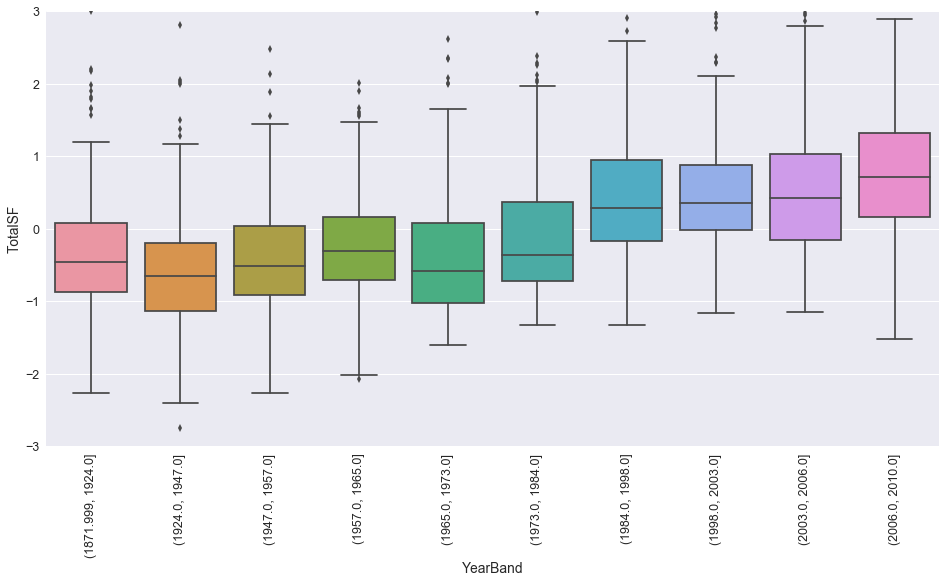

In [27]:
var = 'YearBand'
data = pd.concat([x_features_standardized['TotalSF'], x_features_standardized[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="TotalSF", data=data)
fig.axis(ymin=-3, ymax=3);
plt.xticks(rotation=90);

In [28]:
x_combine = [x_features_logged, x_features_standardized]

for dataset in x_combine:
    dataset.loc[ dataset['YearBuilt'] <= 1871.999, 'YearBuilt'] = 0
    dataset.loc[(dataset['YearBuilt'] > 1871.999) & (dataset['YearBuilt'] <= 1924.0), 'YearBuilt'] = 1
    dataset.loc[(dataset['YearBuilt'] > 1924.0) & (dataset['YearBuilt'] <= 1947.0), 'YearBuilt'] = 2
    dataset.loc[(dataset['YearBuilt'] > 1947.0) & (dataset['YearBuilt'] <= 1958.0), 'YearBuilt'] = 3
    dataset.loc[(dataset['YearBuilt'] > 1958.0) & (dataset['YearBuilt'] <= 1966.0), 'YearBuilt'] = 4
    dataset.loc[(dataset['YearBuilt'] > 1966.0) & (dataset['YearBuilt'] <= 1973.0), 'YearBuilt'] = 5
    dataset.loc[(dataset['YearBuilt'] > 1973.0) & (dataset['YearBuilt'] <= 1985.2), 'YearBuilt'] = 6
    dataset.loc[(dataset['YearBuilt'] > 1985.2) & (dataset['YearBuilt'] <= 1998.0), 'YearBuilt'] = 7
    dataset.loc[(dataset['YearBuilt'] > 1998.0) & (dataset['YearBuilt'] <= 2003.0), 'YearBuilt'] = 8
    dataset.loc[(dataset['YearBuilt'] > 2003.0) & (dataset['YearBuilt'] <= 2006.0), 'YearBuilt'] = 9
    dataset.loc[(dataset['YearBuilt'] > 2006.0) & (dataset['YearBuilt'] <= 2010.0), 'YearBuilt'] = 10
    dataset.loc[ dataset['YearBuilt'] > 2010.0, 'YearBuilt'] = 11
    dataset['YearBuilt'] = dataset['YearBuilt'].astype(int)
    dataset = dataset.drop(['YearBand'], axis=1)

In [29]:
x_features_logged = x_features_logged.drop(['YearBand'], axis=1)
x_features_standardized = x_features_standardized.drop(['YearBand'], axis=1)

In [30]:
x_features_logged.head()

Id  LotFrontage   LotArea  OverallQual  YearBuilt  GrLivArea  \
train_df 0   1     4.174387  9.041922            7          8   7.444249   
         1   2     4.382027  9.169518            6          6   7.140453   
         2   3     4.219508  9.328123            7          8   7.487734   
         3   4     4.094345  9.164296            7          1   7.448334   
         4   5     4.430817  9.565214            8          8   7.695303   

            FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  \
train_df 0         2         1             3             1   
         1         2         0             3             1   
         2         2         1             3             1   
         3         1         0             3             1   
         4         2         1             4             1   

                    ...            SaleType_ConLw  SaleType_New  SaleType_Oth  \
train_df 0          ...                         0             0             0   
         1          ...                         0             0             0   
         2          ...                         0             0             0   
         3          ...                         0             0             0   
         4          ...                         0             0             0   

            SaleType_WD  SaleCondition_Abnorml  SaleCondition_AdjLand  \
train_df 0            1                      0                      0   
         1            1                      0                      0   
         2            1                      0                      0   
         3            1                      1                      0   
         4            1                      0                      0   

            SaleCondition_Alloca  SaleCondition_Family  SaleCondition_Normal  \
train_df 0                     0                     0                     1   
         1                     0                     0                     1   
         2                     0                     0                     1   
         3                     0                     0                     0   
         4                     0                     0                     1   

            SaleCondition_Partial  
train_df 0                      0  
         1                      0  
         2                      0  
         3                      0  
         4                      0  

[5 rows x 204 columns]

In [31]:
x_features_standardized.head()

Id  LotFrontage   LotArea  OverallQual  YearBuilt  GrLivArea  \
train_df 0   1    -0.202033 -0.217841            7          8   0.413476   
         1   2     0.501785 -0.072032            6          6  -0.471810   
         2   3    -0.061269  0.137173            7          8   0.563659   
         3   4    -0.436639 -0.078371            7          1   0.427309   
         4   5     0.689469  0.518814            8          8   1.377806   

            FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  \
train_df 0         2         1             3             1   
         1         2         0             3             1   
         2         2         1             3             1   
         3         1         0             3             1   
         4         2         1             4             1   

                    ...            SaleType_ConLw  SaleType_New  SaleType_Oth  \
train_df 0          ...                         0             0             0   
         1          ...                         0             0             0   
         2          ...                         0             0             0   
         3          ...                         0             0             0   
         4          ...                         0             0             0   

            SaleType_WD  SaleCondition_Abnorml  SaleCondition_AdjLand  \
train_df 0            1                      0                      0   
         1            1                      0                      0   
         2            1                      0                      0   
         3            1                      1                      0   
         4            1                      0                      0   

            SaleCondition_Alloca  SaleCondition_Family  SaleCondition_Normal  \
train_df 0                     0                     0                     1   
         1                     0                     0                     1   
         2                     0                     0                     1   
         3                     0                     0                     0   
         4                     0                     0                     1   

            SaleCondition_Partial  
train_df 0                      0  
         1                      0  
         2                      0  
         3                      0  
         4                      0  

[5 rows x 204 columns]

In [32]:
train_features = x_features_logged.loc['train_df'].drop('Id', axis=1).select_dtypes(include=[np.number]).values
test_features = x_features_logged.loc['test_df'].drop('Id', axis=1).select_dtypes(include=[np.number]).values

train_features_st = x_features_standardized.loc['train_df'].drop('Id', axis=1).select_dtypes(include=[np.number]).values
test_features_st = x_features_standardized.loc['test_df'].drop('Id', axis=1).select_dtypes(include=[np.number]).values

In [33]:
x_train = train_features
y_train_sk = np.log(train_labels)
y_train = np.log(train_labels)[:, np.newaxis]

x_test = test_features

x_train_st = train_features_st
y_train_st = y_train

x_test_st = test_features_st

x_train.shape, y_train_sk.shape, y_train.shape, x_test.shape, x_train_st.shape, y_train_st.shape, x_test_st.shape

((1460, 203),
 (1460,),
 (1460, 1),
 (1459, 203),
 (1460, 203),
 (1460, 1),
 (1459, 203))

In [34]:
x_train

array([[ 4.17438727,  9.04192172,  7.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 4.38202663,  9.16951838,  6.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 4.21950771,  9.32812341,  7.        , ...,  0.        ,
         1.        ,  0.        ],
       ..., 
       [ 4.18965474,  9.10963567,  7.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 4.21950771,  9.18163221,  5.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 4.31748811,  9.20402044,  5.        , ...,  0.        ,
         1.        ,  0.        ]])

In [39]:
tf.reset_default_graph()

In [40]:
learning_rate = 0.001
total_numbers = 20000

X = tf.placeholder(tf.float32, [None, 203])
Y = tf.placeholder(tf.float32, [None, 1])

with tf.variable_scope('cell', reuse=None) as scope:
    W1 = tf.get_variable("Weight1", shape=[203, 1],
                     initializer= tf.contrib.layers.variance_scaling_initializer())
    b1 = tf.Variable(tf.random_normal([1]), name='bias1')
    
    
    
    W2 = tf.get_variable("Weight2", shape=[203, 1],
                     initializer= tf.contrib.layers.variance_scaling_initializer())
    b2 = tf.Variable(tf.random_normal([1]), name='bias2')
    
    
    hypothesis = tf.matmul(X, W1) + b1
    hypothesis_st = tf.matmul(X, W2) + b2
    
    cost = tf.reduce_mean(tf.square(hypothesis - Y))
    cost_st = tf.reduce_mean(tf.square(hypothesis_st - Y))
    
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)
    optimizer_st = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost_st)
    
sess = tf.Session()

sess.run(tf.global_variables_initializer())
    
for step in tqdm(range(total_numbers)):
    c, h, _ = sess.run([cost, hypothesis, optimizer], feed_dict={X: x_train, Y: y_train})
    c_st, h_st, _ = sess.run([cost_st, hypothesis_st, optimizer_st], feed_dict={X: x_train_st, Y: y_train_st})
        
    if step % 100 == 0:
        print(step, "Cost: ", c, "\tCost_st: ", c_st)

0 Cost:  134.461 	Cost_st:  123.777
100 Cost:  0.277669 	Cost_st:  1.01359
200 Cost:  0.202196 	Cost_st:  0.676306
300 Cost:  0.168542 	Cost_st:  0.574823
400 Cost:  0.150447 	Cost_st:  0.527738
500 Cost:  0.13879 	Cost_st:  0.497875
600 Cost:  0.13013 	Cost_st:  0.47505
700 Cost:  0.1231 	Cost_st:  0.455841
800 Cost:  0.117111 	Cost_st:  0.438856
900 Cost:  0.111875 	Cost_st:  0.42343
10347/|/ 52%|| 10347/20000 [03:10<02:57, 54.44it/s]
1000 Cost:  0.107231 	Cost_st:  0.4092
1100 Cost:  0.103073 	Cost_st:  0.395944
1200 Cost:  0.0993235 	Cost_st:  0.383519
1300 Cost:  0.0959237 	Cost_st:  0.371825
1400 Cost:  0.0928259 	Cost_st:  0.360785
1500 Cost:  0.0899908 	Cost_st:  0.350338
1600 Cost:  0.087386 	Cost_st:  0.340435
1700 Cost:  0.0849838 	Cost_st:  0.331031
1800 Cost:  0.0827612 	Cost_st:  0.32209
1900 Cost:  0.080698 	Cost_st:  0.31358
2000 Cost:  0.0787774 	Cost_st:  0.305469
2100 Cost:  0.0769845 	Cost_st:  0.297731
2200 Cost:  0.0753066 	Cost_st:  0.290342
2300 Cost:  0.0737325

19200 Cost:  0.0290551 	Cost_st:  0.056267
19300 Cost:  0.0290063 	Cost_st:  0.0560482
19400 Cost:  0.028958 	Cost_st:  0.0558315
19500 Cost:  0.0289101 	Cost_st:  0.0556169
19600 Cost:  0.0288628 	Cost_st:  0.0554045
19700 Cost:  0.0288158 	Cost_st:  0.055194
19800 Cost:  0.0287693 	Cost_st:  0.0549856
19900 Cost:  0.0287232 	Cost_st:  0.0547793



In [35]:
ENSTest = linear_model.ElasticNetCV(alphas=[0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], l1_ratio=[.01, .1, .5, .9, .99], max_iter=10000, verbose=True).fit(x_train, y_train_sk)
ENSTest_st = linear_model.ElasticNetCV(alphas=[0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], l1_ratio=[.01, .1, .5, .9, .99], max_iter=10000, verbose=True).fit(x_train_st, y_train_sk)

.........................................................................................................[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.6s finished
.........................................................................................................[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.7s finished


In [36]:
GBest = ensemble.GradientBoostingRegressor(n_estimators=5000, learning_rate=0.05, max_depth=3, max_features='sqrt',
                                               min_samples_leaf=15, min_samples_split=10, loss='huber', verbose=True).fit(x_train, y_train_sk)
GBest_st = ensemble.GradientBoostingRegressor(n_estimators=5000, learning_rate=0.05, max_depth=3, max_features='sqrt',
                                               min_samples_leaf=15, min_samples_split=10, loss='huber', verbose=True).fit(x_train_st, y_train_sk)

      Iter       Train Loss   Remaining Time 
         1           0.0724           11.94s
         2           0.0680           15.48s
         3           0.0648           15.55s
         4           0.0617           16.07s
         5           0.0579           16.59s
         6           0.0553           17.11s
         7           0.0530           16.55s
         8           0.0501           16.48s
         9           0.0479           15.80s
        10           0.0459           15.40s
        20           0.0300           13.01s
        30           0.0210           12.25s
        40           0.0163           11.71s
        50           0.0130           11.43s
        60           0.0112           11.45s
        70           0.0100           11.06s
        80           0.0091           10.73s
        90           0.0084           10.44s
       100           0.0079           10.39s
       200           0.0057            9.88s
       300           0.0048            9.33s
       40

In [ ]:
gbm = xgb.XGBClassifier(
    learning_rate = 0.001,
 n_estimators= 400,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'reg:linear',
 nthread= -1,
 scale_pos_weight=1, verbose=True).fit(x_train, y_train_sk)

predictions = gbm.predict(x_test)


gbm_st = xgb.XGBClassifier(
    #learning_rate = 0.001,
 n_estimators= 400,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'reg:linear',
 nthread= -1,
 scale_pos_weight=1, verbose=True).fit(x_train_st, y_train_sk)

predictions_st = gbm_st.predict(x_test)

In [307]:
sk_result = ((np.exp(GBest.predict(x_test)) + (np.exp(GBest_st.predict(x_test_st)) + np.exp(ENSTest.predict(x_test))) + np.exp(ENSTest_st.predict(x_test_st))))[:, np.newaxis]

resData1 = np.asarray(sess.run(hypothesis, feed_dict={X: x_test}))
resData2 = np.asarray(sess.run(hypothesis_st, feed_dict={X: x_test_st}))
tf_result = (np.exp(resData1) + np.exp(resData2))

final_result = (sk_result + tf_result) / 6
Final_labels = pd.DataFrame(data=final_result, index=test_df.Id, columns=['SalePrice'])

Final_labels

,SalePrice
Id,
1461,119143.609293
1462,159958.268838
1463,180067.117076
1464,201024.131877
1465,197110.223549
1466,169430.581766
1467,174983.759171
1468,165551.437130
1469,183127.683805


In [308]:
Final_labels.to_csv('result.csv')